In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from utils import split_sentiment, split_train_test

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, Reshape, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

from gensim.models import Word2Vec

In [3]:
df = pd.read_csv("cleaned_data/cleaned_reviews_2.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review_id,text,sentiment,detoken
0,705b4be0c87fc1a69fbbd6a12d4973a7,"[ugh, hat, last, book, in, series, poor, way, ...",0,ugh hat last book in series poor way end trilogy
1,9c8dfa25aa1c02eaa1784558401ada6c,"[start, out, strong, but, go, downhill, fairly...",0,start out strong but go downhill fairly quickl...
2,674c63c16f14e97d0d5b92237d061e04,"[decently, write, ya, book, but, can, even, co...",0,decently write ya book but can even consider e...
3,e59c12c5107de7baeffa922d37f9b862,"[book, simultaneously, bore, death, annoy, hel...",0,book simultaneously bore death annoy hell out ...
4,6805d23d0e5030a6bb9b6666623bedea,"[ugh, try, honestly, try, huge, fan, scott, we...",0,ugh try honestly try huge fan scott westerfeld...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  20000 non-null  object
 1   text       20000 non-null  object
 2   sentiment  20000 non-null  int64 
 3   detoken    20000 non-null  object
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [4]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 1417110 train words in total and the vocabulary size is 31024.


In [19]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 200

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

200
(16000, 200)
(4000, 200)
(16000,)
(4000,)
Found 31058 unique tokens


In [ ]:
# Build model

model = Sequential()
model.add(Embedding(20000, 256, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5))
model.add(Activation("relu"))
model.add(MaxPooling1D(5))
model.add(Conv1D(filters=128, kernel_size=5))
model.add(Activation("relu"))
model.add(MaxPooling1D(5))
model.add(Conv1D(filters=64, kernel_size=5))
model.add(Activation("relu"))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

In [ ]:
# Compile model

EPOCHS = 2
LEARNING_RATE = 0.5
DECAY_RATE = LEARNING_RATE / EPOCHS
MOMENTUM = 0.1

optimizer = Adam(learning_rate=LEARNING_RATE)
# optimizer = SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Checkpoint

checkpoint_path = "weights.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Fit model

BATCH_SIZE = 64

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=callbacks_list, validation_split=0.2)

In [ ]:
# Plotting accuracy on training data

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

## WITH WORD2VEC

In [ ]:
df_train["text"].tolist()

In [ ]:
all_sents = df_train["text"]
all_tokens = []
for sent in all_sents:
    all_tokens += sent

set_tokens = set(all_tokens)
print(f"Total of words: {len(all_tokens)}. Vocab size: {len(set_tokens)}")

In [ ]:
# train_data as list of lists (of the train reviews)
wtv_model = Word2Vec(df_train["text"].tolist(), min_count=1)
wtv_model.save("word2vec.model")
wtv_model.wv.save_word2vec_format("word2vec.txt", binary=False)

In [ ]:
wtv_model = Word2Vec.load("word2vec.model")
print(f"Length of model is equals to vocab size: {len(wtv_model.wv)}")

word = "slow"
word_idx = wtv_model.wv.key_to_index[word]
word_vector = wtv_model.wv.get_vector(word, norm=True)
print(word_idx)
print(wtv_model.wv.most_similar(word))

## Glove Embeddings

In [6]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [20]:
def vocab_build(review_set):

    vocab = Counter()

    for review in review_set:
        for token in review:
            vocab[token] += 1

    return vocab

vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

In [21]:
def embedding_coverage(review_set, embeddings_dict):
    
    vocab = vocab_build(review_set)

    covered = {}
    word_count = {}
    oov = {}
    covered_num = 0
    oov_num = 0

    for word in vocab:
        try:
            covered[word] = embeddings_dict[word]
            covered_num += vocab[word]
            word_count[word] = vocab[word]
        
        except:
            oov[word] = vocab[word]
            oov_num += oov[word]

    vocab_coverage = len(covered) / len(vocab) * 100
    text_coverage = covered_num / (covered_num + oov_num) * 100
    
    return word_count, oov, vocab_coverage, text_coverage

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"],embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 91.69% of vocabulary and 99.72% text in training set
Glove embeddings cover 95.95% of vocabulary and 99.74% text in testing set


In [30]:
EMBEDDING_DIM = 300
MAX_WORDS = 20000
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False)

del(embedding_matrix)

In [31]:
sequence_input = Input(shape=(max_length,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)

In [32]:
EPOCHS = 10
LEARNING_RATE = 0.001
DECAY_RATE = LEARNING_RATE / EPOCHS
MOMENTUM = 0.1

optimizer = Adam(learning_rate=LEARNING_RATE)
# optimizer = SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# checkpoint_path = "weights.best.hdf5"
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [33]:
# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 16s 75ms/step - loss: 0.4801 - accuracy: 0.7609 - val_loss: 0.3211 - val_accuracy: 0.8753
Epoch 2/10
200/200 [==============================] - 14s 72ms/step - loss: 0.3174 - accuracy: 0.8639 - val_loss: 0.4181 - val_accuracy: 0.8213
Epoch 3/10
200/200 [==============================] - 14s 72ms/step - loss: 0.2527 - accuracy: 0.8951 - val_loss: 0.8715 - val_accuracy: 0.6300
Epoch 4/10
200/200 [==============================] - 21s 105ms/step - loss: 0.1770 - accuracy: 0.9283 - val_loss: 0.7715 - val_accuracy: 0.6650
Epoch 5/10
200/200 [==============================] - 16s 80ms/step - loss: 0.1404 - accuracy: 0.9463 - val_loss: 0.2981 - val_accuracy: 0.8697
Epoch 6/10
200/200 [==============================] - 18s 88ms/step - loss: 0.0919 - accuracy: 0.9640 - val_loss: 0.4083 - val_accuracy: 0.8534
Epoch 7/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0710 - accuracy: 0.9705 - val_loss: 0.6151 - val_accuracy

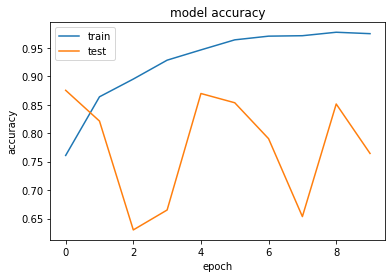

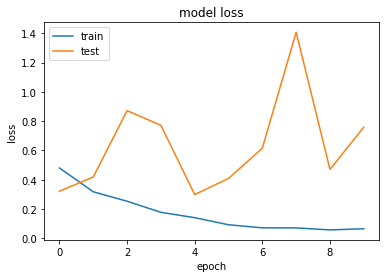

In [34]:
# Plotting accuracy on training data

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

125/125 - 2s - loss: 0.5085 - accuracy: 0.8363 - 2s/epoch - 16ms/step
Test accuracy: 0.8362500071525574
